In [ ]:
# 1. 환경 설정 및 라이브러리 임포트

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# M1 Mac GPU 설정
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# 시드 설정
np.random.seed(42)
tf.random.set_seed(42)

TensorFlow version: 2.19.0
GPU Available: []


In [2]:
# 2. 데이터 로드 및 전처리
# 데이터 로드
person_df = pd.read_csv('person.csv')
chair_df = pd.read_excel('chair.xlsx')
person_test_df = pd.read_excel('person_test.xlsx')

# Chair numerical columns
chair_numerical_cols = [
    'h8_지면-좌석 높이_MIN', 'h8_지면-좌석 높이_MAX',
    'b3_좌석 가로 길이', 't4_좌석 세로 길이 일반',
    'b4_등받이 가로 길이', 'h7_등받이 세로 길이'
]

# 의자 이름 컬럼
chair_name_col = chair_df.columns[2]

# 단위 통일 (person cm -> mm)
person_cols_to_convert = ['A_Buttock-popliteal length', 'B_Popliteal-height', 
                         'C_Hip-breadth', 'F_Sitting-height', 'G_Shoulder-breadth']

for col in person_cols_to_convert:
    person_df[col] = person_df[col] * 10  # cm to mm
    person_test_df[col] = person_test_df[col] * 10

# human-height도 mm로 변환
person_df['human-height'] = person_df['human-height'] * 10
person_test_df['human-height'] = person_test_df['human-height'] * 10

print("Person data shape:", person_df.shape)
print("Chair data shape:", chair_df.shape)
print("Test person data shape:", person_test_df.shape)
print("\nChair numerical columns found:", len(chair_numerical_cols))

Person data shape: (14, 7)
Chair data shape: (107, 18)
Test person data shape: (4, 7)

Chair numerical columns found: 6


In [3]:
# 3. 매칭 점수 계산 함수
def calculate_matching_score(person_row, chair_row):
    """사람과 의자의 매칭 점수 계산"""
    scores = []
    
    # 1. Buttock-popliteal length < t4
    if chair_row['t4_좌석 세로 길이 일반'] > person_row['A_Buttock-popliteal length']:
        scores.append(1.0)
    else:
        diff = person_row['A_Buttock-popliteal length'] - chair_row['t4_좌석 세로 길이 일반']
        scores.append(max(0, 1 - diff/100))
    
    # 2. Popliteal height ≈ h8
    h8_min = chair_row['h8_지면-좌석 높이_MIN']
    h8_max = chair_row['h8_지면-좌석 높이_MAX']
    
    if h8_min <= person_row['B_Popliteal-height'] <= h8_max:
        scores.append(1.0)
    else:
        diff = min(abs(person_row['B_Popliteal-height'] - h8_min),
                  abs(person_row['B_Popliteal-height'] - h8_max))
        scores.append(max(0, 1 - diff/50))
    
    # 3. Hip breadth < b3
    if chair_row['b3_좌석 가로 길이'] > person_row['C_Hip-breadth']:
        scores.append(1.0)
    else:
        diff = person_row['C_Hip-breadth'] - chair_row['b3_좌석 가로 길이']
        scores.append(max(0, 1 - diff/50))
    
    # 4. Sitting height > h7
    if chair_row['h7_등받이 세로 길이'] < person_row['F_Sitting-height']:
        scores.append(1.0)
    else:
        diff = chair_row['h7_등받이 세로 길이'] - person_row['F_Sitting-height']
        scores.append(max(0, 1 - diff/100))
    
    # 5. Shoulder breadth <= b4
    if chair_row['b4_등받이 가로 길이'] >= person_row['G_Shoulder-breadth']:
        scores.append(1.0)
    else:
        diff = person_row['G_Shoulder-breadth'] - chair_row['b4_등받이 가로 길이']
        scores.append(max(0, 1 - diff/50))
    
    return np.mean(scores)

In [4]:
# 4. xDeepFM + DRM 모델 구현
class xDeepFMWithDRM(tf.keras.Model):
    def __init__(self, feature_dim, field_size, embedding_size=8,
                 cin_layer_sizes=[128, 128], dnn_hidden_units=[128, 128],
                 dnn_dropout=0.2, l2_reg=0.0001, num_items=None):
        super(xDeepFMWithDRM, self).__init__()
        
        self.feature_dim = feature_dim
        self.field_size = field_size
        self.embedding_size = embedding_size
        self.num_items = num_items
        
        # Linear part
        self.linear = layers.Dense(1, kernel_regularizer=regularizers.l2(l2_reg))
        
        # DNN part
        self.dnn_layers = []
        self.dropout_layers = []
        self.batch_norm_layers = []
        
        for hidden_unit in dnn_hidden_units:
            self.dnn_layers.append(layers.Dense(hidden_unit, activation='relu',
                                              kernel_regularizer=regularizers.l2(l2_reg)))
            self.dropout_layers.append(layers.Dropout(dnn_dropout))
            self.batch_norm_layers.append(layers.BatchNormalization())
        
        self.dnn_final = layers.Dense(1, kernel_regularizer=regularizers.l2(l2_reg))
        
        # Simplified CIN part - using standard dense layers for interaction
        self.cin_layer_sizes = cin_layer_sizes
        self.cin_layers = []
        
        # CIN layers process interactions
        input_dim = field_size
        for size in cin_layer_sizes:
            self.cin_layers.append(
                layers.Dense(size, activation='relu',
                           kernel_regularizer=regularizers.l2(l2_reg))
            )
        
        # CIN output layer
        self.cin_output_layer = layers.Dense(1, kernel_regularizer=regularizers.l2(l2_reg))
        
        # Final probability layer (before DRM)
        self.final_dense = layers.Dense(1, activation='sigmoid')
        
        # DRM components
        self.drm_transform = layers.Dense(64, activation='relu')
        self.drm_output = layers.Dense(1, activation=None)  # No activation for ranking score
        
    def compressed_interaction_network(self, inputs, training=False):
        """Simplified CIN implementation"""
        # Start with input features
        x = inputs
        
        # Apply CIN layers sequentially
        for layer in self.cin_layers:
            x = layer(x)
            
        # Final CIN output
        cin_output = self.cin_output_layer(x)
        
        return cin_output
    
    def drm_layer(self, probabilities):
        """DRM (Differentiable Ranking Metric) layer"""
        # Transform probabilities through neural network
        drm_features = self.drm_transform(probabilities)
        
        # Generate ranking scores (unbounded)
        ranking_scores = self.drm_output(drm_features)
        
        return ranking_scores
    
    def call(self, inputs, training=False):
        # Linear part
        linear_output = self.linear(inputs)
        
        # DNN part
        dnn_input = inputs
        for i, (dense, dropout, batch_norm) in enumerate(zip(self.dnn_layers, 
                                                            self.dropout_layers, 
                                                            self.batch_norm_layers)):
            dnn_input = dense(dnn_input)
            dnn_input = batch_norm(dnn_input, training=training)
            dnn_input = dropout(dnn_input, training=training)
        
        dnn_output = self.dnn_final(dnn_input)
        
        # CIN part
        cin_output = self.compressed_interaction_network(inputs, training)
        
        # Combine all parts for probability prediction
        final_input = tf.concat([linear_output, dnn_output, cin_output], axis=1)
        probability = self.final_dense(final_input)
        
        # Apply DRM to convert probability to ranking score
        ranking_score = self.drm_layer(probability)
        
        return probability, ranking_score

In [5]:
# 5. 학습 데이터 생성
def create_feature_vector(person, chair):
    """특징 벡터 생성"""
    features = []
    
    # Person features (6)
    features.extend([
        person['A_Buttock-popliteal length'],
        person['B_Popliteal-height'],
        person['C_Hip-breadth'],
        person['F_Sitting-height'],
        person['G_Shoulder-breadth'],
        person['human-height']
    ])
    
    # Chair features (6)
    features.extend([
        chair['t4_좌석 세로 길이 일반'],
        chair['h8_지면-좌석 높이_MIN'],
        chair['h8_지면-좌석 높이_MAX'],
        chair['b3_좌석 가로 길이'],
        chair['h7_등받이 세로 길이'],
        chair['b4_등받이 가로 길이']
    ])
    
    # Cross features - differences (5)
    features.extend([
        chair['t4_좌석 세로 길이 일반'] - person['A_Buttock-popliteal length'],
        chair['b3_좌석 가로 길이'] - person['C_Hip-breadth'],
        person['F_Sitting-height'] - chair['h7_등받이 세로 길이'],
        chair['b4_등받이 가로 길이'] - person['G_Shoulder-breadth'],
        (chair['h8_지면-좌석 높이_MIN'] + chair['h8_지면-좌석 높이_MAX'])/2 - person['B_Popliteal-height']
    ])
    
    # Cross features - ratios (5)
    features.extend([
        chair['t4_좌석 세로 길이 일반'] / (person['A_Buttock-popliteal length'] + 1),
        chair['b3_좌석 가로 길이'] / (person['C_Hip-breadth'] + 1),
        chair['h7_등받이 세로 길이'] / (person['F_Sitting-height'] + 1),
        chair['b4_등받이 가로 길이'] / (person['G_Shoulder-breadth'] + 1),
        person['human-height'] / ((chair['h8_지면-좌석 높이_MIN'] + chair['h8_지면-좌석 높이_MAX'])/2 + 1)
    ])
    
    return features

# 학습 데이터 생성
print("Creating training data...")
training_data = []

for p_idx, person in person_df.iterrows():
    for c_idx, chair in chair_df.iterrows():
        features = create_feature_vector(person, chair)
        score = calculate_matching_score(person, chair)
        
        training_data.append({
            'person_idx': p_idx,
            'chair_idx': c_idx,
            'chair_name': chair[chair_name_col],
            'features': features,
            'score': score,
            'label': 1 if score > 0.8 else 0
        })

train_df = pd.DataFrame(training_data)
print(f"Total samples: {len(train_df)}")
print(f"Feature dimension: {len(train_df['features'].iloc[0])}")
print(f"Positive samples: {sum(train_df['label'])} ({sum(train_df['label'])/len(train_df)*100:.1f}%)")
print(f"Negative samples: {len(train_df) - sum(train_df['label'])} ({(len(train_df) - sum(train_df['label']))/len(train_df)*100:.1f}%)")

Creating training data...
Total samples: 1498
Feature dimension: 22
Positive samples: 176 (11.7%)
Negative samples: 1322 (88.3%)


In [6]:
# 6. 데이터 준비 및 스케일링
# 특징 추출 및 정규화
X = np.array(train_df['features'].tolist())
y = np.array(train_df['label'])
scores = np.array(train_df['score'])

# 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Validation 분할
X_train, X_val, y_train, y_val, scores_train, scores_val = train_test_split(
    X_scaled, y, scores, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Number of features: {X_train.shape[1]}")

Train shape: (1198, 22)
Validation shape: (300, 22)
Number of features: 22


In [7]:
# 7. 모델 학습
# 모델 생성
model = xDeepFMWithDRM(
    feature_dim=X_train.shape[1],
    field_size=X_train.shape[1],
    embedding_size=8,
    cin_layer_sizes=[32, 32],
    dnn_hidden_units=[64, 32],
    dnn_dropout=0.3,
    l2_reg=0.001,
    num_items=len(chair_df)
)

# 먼저 모델을 빌드
model.build(input_shape=(None, X_train.shape[1]))

# Custom training step for handling dual outputs
class CustomModel(tf.keras.Model):
    def __init__(self, xdeepfm_model):
        super(CustomModel, self).__init__()
        self.xdeepfm_model = xdeepfm_model
        
    def call(self, inputs, training=False):
        return self.xdeepfm_model(inputs, training=training)
    
    def train_step(self, data):
        x, y = data
        
        with tf.GradientTape() as tape:
            # Forward pass
            probability, ranking_score = self(x, training=True)
            
            # Reshape y to match probability shape
            y_reshaped = tf.reshape(y, [-1, 1])
            
            # Binary crossentropy for classification
            bce_loss = tf.keras.losses.binary_crossentropy(y_reshaped, probability)
            
            # Ranking loss
            # TensorFlow 타입 문제 해결
            threshold = tf.constant(0.5, dtype=tf.float32)
            positive_mask = tf.cast(tf.greater(y_reshaped, threshold), tf.float32)
            negative_mask = 1.0 - positive_mask
            
            # We want positive samples to have higher ranking scores
            pos_count = tf.reduce_sum(positive_mask) + 1e-7
            neg_count = tf.reduce_sum(negative_mask) + 1e-7
            
            pos_scores = tf.reduce_sum(ranking_score * positive_mask) / pos_count
            neg_scores = tf.reduce_sum(ranking_score * negative_mask) / neg_count
            
            # Margin ranking loss
            margin = tf.constant(1.0, dtype=tf.float32)
            ranking_loss = tf.maximum(0.0, margin - (pos_scores - neg_scores))
            
            # Combined loss
            total_loss = tf.reduce_mean(bce_loss) + 0.1 * ranking_loss
            
        # Compute gradients
        gradients = tape.gradient(total_loss, self.trainable_variables)
        
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # Calculate accuracy
        predictions = tf.cast(tf.greater(probability, 0.5), tf.float32)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, y_reshaped), tf.float32))
        
        # Return metrics
        return {
            'loss': total_loss,
            'accuracy': accuracy,
            'bce_loss': tf.reduce_mean(bce_loss),
            'ranking_loss': ranking_loss
        }
    
    def test_step(self, data):
        x, y = data
        
        # Forward pass
        probability, ranking_score = self(x, training=False)
        
        # Reshape y to match probability shape
        y_reshaped = tf.reshape(y, [-1, 1])
        
        # Calculate metrics
        bce_loss = tf.keras.losses.binary_crossentropy(y_reshaped, probability)
        predictions = tf.cast(tf.greater(probability, 0.5), tf.float32)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, y_reshaped), tf.float32))
        
        return {
            'loss': tf.reduce_mean(bce_loss),
            'accuracy': accuracy
        }

# Create custom model
custom_model = CustomModel(model)

# Compile
custom_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

# Custom callback to track metrics
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []
        
    def on_epoch_end(self, epoch, logs=None):
        # 로그가 None이 아닌 경우에만 추가
        if logs is not None:
            self.train_losses.append(logs.get('loss', 0))
            self.val_losses.append(logs.get('val_loss', 0))
            self.train_accs.append(logs.get('accuracy', 0))
            self.val_accs.append(logs.get('val_accuracy', 0))
            
            # 5 에폭마다 상태 출력
            if (epoch + 1) % 5 == 0:
                print(f"\nEpoch {epoch + 1} Summary:")
                print(f"  Train Loss: {logs.get('loss', 0):.4f}, Train Acc: {logs.get('accuracy', 0):.4f}")
                print(f"  Val Loss: {logs.get('val_loss', 0):.4f}, Val Acc: {logs.get('val_accuracy', 0):.4f}")

metrics_callback = MetricsCallback()

# Other callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # accuracy 대신 loss 사용
    patience=15,
    restore_best_weights=True,
    mode='min'  # loss는 minimize
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    mode='min'
)

# Y 데이터 타입 확인 및 변환
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)

print(f"X_train shape: {X_train.shape}, dtype: {X_train.dtype}")
print(f"y_train shape: {y_train.shape}, dtype: {y_train.dtype}")
print(f"Unique values in y_train: {np.unique(y_train)}")

# Training
print("\nStarting training...")
history = custom_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=256,
    callbacks=[metrics_callback, early_stopping, reduce_lr],
    verbose=1
)

X_train shape: (1198, 22), dtype: float64
y_train shape: (1198,), dtype: float32
Unique values in y_train: [0. 1.]

Starting training...
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8867 - bce_loss: nan - loss: nan - ranking_loss: nan - val_accuracy: 0.8864 - val_loss: nan - learning_rate: 0.0010
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8867 - bce_loss: nan - loss: nan - ranking_loss: nan - val_accuracy: 0.8864 - val_loss: nan - learning_rate: 0.0010
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8867 - bce_loss: nan - loss: nan - ranking_loss: nan - val_accuracy: 0.8864 - val_loss: nan - learning_rate: 0.0010
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8867 - bce_loss: nan - loss: nan - ranking_loss: nan - val_accuracy: 0.8864 - val_loss: nan - learning_rate: 0.0010
Epoch 5/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8711 - bce_loss: nan - loss: nan - ranking_loss: nan
Epoch 5 Summary:
  Train Loss: 

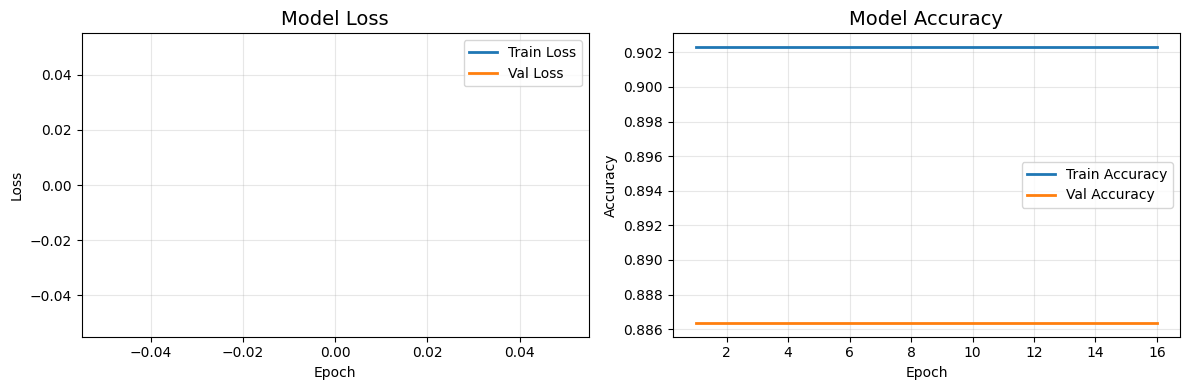


Training completed at epoch 16
Final Train Loss: nan
Final Val Loss: nan
Final Train Accuracy: 0.9023
Final Val Accuracy: 0.8864

Best validation accuracy: 0.8864 at epoch 1


In [8]:
# 8. 학습 곡선 시각화
# 학습 곡선 플로팅
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
epochs = range(1, len(metrics_callback.train_losses) + 1)
axes[0].plot(epochs, metrics_callback.train_losses, label='Train Loss', linewidth=2)
axes[0].plot(epochs, metrics_callback.val_losses, label='Val Loss', linewidth=2)
axes[0].set_title('Model Loss', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs, metrics_callback.train_accs, label='Train Accuracy', linewidth=2)
axes[1].plot(epochs, metrics_callback.val_accs, label='Val Accuracy', linewidth=2)
axes[1].set_title('Model Accuracy', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 최종 성능
final_epoch = len(metrics_callback.train_losses)
print(f"\nTraining completed at epoch {final_epoch}")
print(f"Final Train Loss: {metrics_callback.train_losses[-1]:.4f}")
print(f"Final Val Loss: {metrics_callback.val_losses[-1]:.4f}")
print(f"Final Train Accuracy: {metrics_callback.train_accs[-1]:.4f}")
print(f"Final Val Accuracy: {metrics_callback.val_accs[-1]:.4f}")

# 추가 분석
best_epoch = np.argmax(metrics_callback.val_accs) + 1
print(f"\nBest validation accuracy: {max(metrics_callback.val_accs):.4f} at epoch {best_epoch}")

In [9]:
# 9. 테스트 데이터 추천 함수
def get_recommendations_with_drm(person_data, chair_df, model, scaler, top_k=5):
    """DRM을 사용한 의자 추천"""
    recommendations = []
    
    for c_idx, chair in chair_df.iterrows():
        # 특징 생성
        features = create_feature_vector(person_data, chair)
        features_scaled = scaler.transform([features])
        
        # 예측 (probability와 ranking score)
        predictions = model.predict(features_scaled, verbose=0)
        if isinstance(predictions, tuple):
            prob, ranking_score = predictions
            prob = prob[0][0]
            ranking_score = ranking_score[0][0]
        else:
            # 단일 출력인 경우
            prob = predictions[0][0]
            ranking_score = prob
        
        # 매칭 상세 정보
        matching_details = {
            'buttock_fit': chair['t4_좌석 세로 길이 일반'] > person_data['A_Buttock-popliteal length'],
            'height_fit': chair['h8_지면-좌석 높이_MIN'] <= person_data['B_Popliteal-height'] <= chair['h8_지면-좌석 높이_MAX'],
            'hip_fit': chair['b3_좌석 가로 길이'] > person_data['C_Hip-breadth'],
            'back_fit': chair['h7_등받이 세로 길이'] < person_data['F_Sitting-height'],
            'shoulder_fit': chair['b4_등받이 가로 길이'] >= person_data['G_Shoulder-breadth']
        }
        
        recommendations.append({
            'chair_name': chair[chair_name_col],
            'chair_idx': c_idx,
            'probability': float(prob),
            'ranking_score': float(ranking_score),
            'matching_details': matching_details
        })
    
    # Ranking score로 정렬 (DRM 적용)
    recommendations.sort(key=lambda x: x['ranking_score'], reverse=True)
    return recommendations[:top_k]

In [10]:
# 10. 테스트 데이터에 대한 추천 생성
# 테스트 데이터에 대한 추천 생성
print("Generating recommendations for test data...")
test_recommendations = {}

for idx, person in person_test_df.iterrows():
    person_id = person['image-name']
    recommendations = get_recommendations_with_drm(person, chair_df, model, scaler, top_k=5)
    test_recommendations[person_id] = recommendations
    
    print(f"\n{'='*60}")
    print(f"Recommendations for {person_id}")
    print(f"{'='*60}")
    print(f"Person measurements:")
    print(f"  - Height: {person['human-height']/10:.1f} cm")
    print(f"  - Buttock-popliteal: {person['A_Buttock-popliteal length']/10:.1f} cm")
    print(f"  - Popliteal height: {person['B_Popliteal-height']/10:.1f} cm")
    print(f"  - Hip breadth: {person['C_Hip-breadth']/10:.1f} cm")
    print(f"  - Sitting height: {person['F_Sitting-height']/10:.1f} cm")
    print(f"  - Shoulder breadth: {person['G_Shoulder-breadth']/10:.1f} cm")
    
    print(f"\nTop 5 recommended chairs:")
    for i, rec in enumerate(recommendations, 1):
        print(f"\n{i}. {rec['chair_name']}")
        print(f"   - Probability: {rec['probability']:.3f}")
        print(f"   - Ranking Score: {rec['ranking_score']:.3f}")
        print(f"   - Fit details:")
        for key, value in rec['matching_details'].items():
            status = '✓' if value else '✗'
            print(f"     • {key}: {status}")

Generating recommendations for test data...

Recommendations for 할머니
Person measurements:
  - Height: 156.0 cm
  - Buttock-popliteal: 52.0 cm
  - Popliteal height: 35.0 cm
  - Hip breadth: 32.0 cm
  - Sitting height: 40.0 cm
  - Shoulder breadth: 33.0 cm

Top 5 recommended chairs:

1. 뮤즈 편한 팔걸이 컴퓨터 메쉬 사무용 책상 의자
   - Probability: nan
   - Ranking Score: nan
   - Fit details:
     • buttock_fit: ✗
     • height_fit: ✗
     • hip_fit: ✗
     • back_fit: ✗
     • shoulder_fit: ✗

2. 뮤즈 편한 팔걸이 헤드형 컴퓨터 메쉬 책상 의자
   - Probability: nan
   - Ranking Score: nan
   - Fit details:
     • buttock_fit: ✗
     • height_fit: ✗
     • hip_fit: ✗
     • back_fit: ✗
     • shoulder_fit: ✗

3. [무료배송]버디시리즈(CPS) 아마존 최다판매 학생용사무용 메쉬의자
   - Probability: nan
   - Ranking Score: nan
   - Fit details:
     • buttock_fit: ✗
     • height_fit: ✗
     • hip_fit: ✓
     • back_fit: ✗
     • shoulder_fit: ✓

4. [무료배송]버디시리즈(CPSH) 아마존 최다판매 학생용사무용 메쉬의자
   - Probability: nan
   - Ranking Score: nan
   - Fit details:
     •

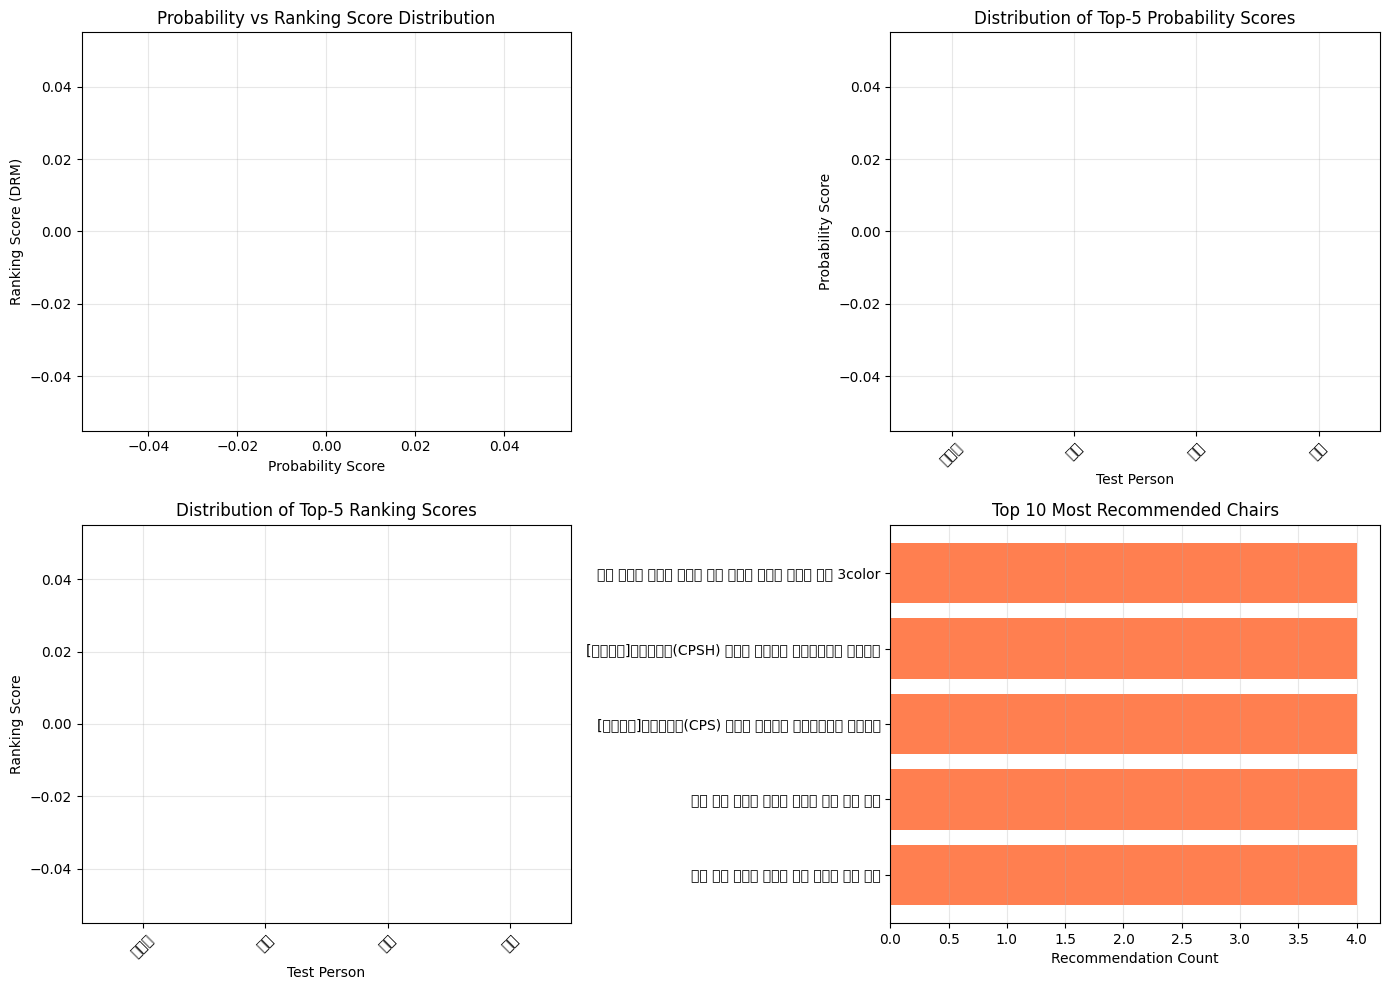


Recommendation Statistics:
Average top-1 probability score: nan
Average top-1 ranking score: nan

Most recommended chair: 뮤즈 편한 팔걸이 컴퓨터 메쉬 사무용 책상 의자 (4 times)


In [11]:
# 11. 추천 결과 분석 및 시각화
# 추천 점수 분포 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Probability vs Ranking Score 분포
all_probs = []
all_ranks = []
for person_id, recs in test_recommendations.items():
    all_probs.extend([rec['probability'] for rec in recs])
    all_ranks.extend([rec['ranking_score'] for rec in recs])

axes[0, 0].scatter(all_probs, all_ranks, alpha=0.6)
axes[0, 0].set_xlabel('Probability Score')
axes[0, 0].set_ylabel('Ranking Score (DRM)')
axes[0, 0].set_title('Probability vs Ranking Score Distribution')
axes[0, 0].grid(True, alpha=0.3)

# 2. 각 사용자별 추천 점수 분포
person_names = list(test_recommendations.keys())
prob_scores = [[rec['probability'] for rec in recs] for recs in test_recommendations.values()]
rank_scores = [[rec['ranking_score'] for rec in recs] for recs in test_recommendations.values()]

# Probability scores boxplot
bp1 = axes[0, 1].boxplot(prob_scores, labels=person_names, patch_artist=True)
for patch in bp1['boxes']:
    patch.set_facecolor('lightblue')
axes[0, 1].set_xlabel('Test Person')
axes[0, 1].set_ylabel('Probability Score')
axes[0, 1].set_title('Distribution of Top-5 Probability Scores')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Ranking scores boxplot
bp2 = axes[1, 0].boxplot(rank_scores, labels=person_names, patch_artist=True)
for patch in bp2['boxes']:
    patch.set_facecolor('lightgreen')
axes[1, 0].set_xlabel('Test Person')
axes[1, 0].set_ylabel('Ranking Score')
axes[1, 0].set_title('Distribution of Top-5 Ranking Scores')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# 4. 가장 많이 추천된 의자
all_chair_names = []
for recs in test_recommendations.values():
    all_chair_names.extend([rec['chair_name'] for rec in recs])

from collections import Counter
chair_counts = Counter(all_chair_names)
top_chairs = chair_counts.most_common(10)

chair_names = [chair[0] for chair in top_chairs]
counts = [chair[1] for chair in top_chairs]

axes[1, 1].barh(chair_names, counts, color='coral')
axes[1, 1].set_xlabel('Recommendation Count')
axes[1, 1].set_title('Top 10 Most Recommended Chairs')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# 통계 출력
print("\nRecommendation Statistics:")
print(f"Average top-1 probability score: {np.mean([recs[0]['probability'] for recs in test_recommendations.values()]):.3f}")
print(f"Average top-1 ranking score: {np.mean([recs[0]['ranking_score'] for recs in test_recommendations.values()]):.3f}")
print(f"\nMost recommended chair: {top_chairs[0][0]} ({top_chairs[0][1]} times)")

In [12]:
# 12. 추천 결과 저장
# 추천 결과를 CSV로 저장
recommendations_list = []

for person_id, recs in test_recommendations.items():
    for rank, rec in enumerate(recs, 1):
        fit_count = sum(rec['matching_details'].values())
        recommendations_list.append({
            'person_id': person_id,
            'rank': rank,
            'chair_name': rec['chair_name'],
            'probability_score': rec['probability'],
            'ranking_score': rec['ranking_score'],
            'fit_count': fit_count,
            'buttock_fit': rec['matching_details']['buttock_fit'],
            'height_fit': rec['matching_details']['height_fit'],
            'hip_fit': rec['matching_details']['hip_fit'],
            'back_fit': rec['matching_details']['back_fit'],
            'shoulder_fit': rec['matching_details']['shoulder_fit']
        })

recommendations_df = pd.DataFrame(recommendations_list)
recommendations_df.to_csv('chair_recommendations_xdeepfm_drm.csv', index=False)
print("Recommendations saved to 'chair_recommendations_xdeepfm_drm.csv'")

# 요약 테이블 생성
summary_df = recommendations_df[recommendations_df['rank'] == 1].copy()
summary_df = summary_df[['person_id', 'chair_name', 'probability_score', 'ranking_score', 'fit_count']]
print("\nTop-1 Recommendations Summary:")
print(summary_df)

# 적합도 분석
print("\nFit Analysis for Top-1 Recommendations:")
fit_cols = ['buttock_fit', 'height_fit', 'hip_fit', 'back_fit', 'shoulder_fit']
top1_df = recommendations_df[recommendations_df['rank'] == 1]
for col in fit_cols:
    fit_rate = top1_df[col].mean() * 100
    print(f"{col}: {fit_rate:.1f}% fit rate")

Recommendations saved to 'chair_recommendations_xdeepfm_drm.csv'

Top-1 Recommendations Summary:
   person_id                  chair_name  probability_score  ranking_score  \
0        할머니  뮤즈 편한 팔걸이 컴퓨터 메쉬 사무용 책상 의자                NaN            NaN   
5         다온  뮤즈 편한 팔걸이 컴퓨터 메쉬 사무용 책상 의자                NaN            NaN   
10        민아  뮤즈 편한 팔걸이 컴퓨터 메쉬 사무용 책상 의자                NaN            NaN   
15        재원  뮤즈 편한 팔걸이 컴퓨터 메쉬 사무용 책상 의자                NaN            NaN   

    fit_count  
0           0  
5           0  
10          0  
15          0  

Fit Analysis for Top-1 Recommendations:
buttock_fit: 0.0% fit rate
height_fit: 0.0% fit rate
hip_fit: 0.0% fit rate
back_fit: 0.0% fit rate
shoulder_fit: 0.0% fit rate
